<a href="https://colab.research.google.com/github/periclesrialto/PatternRecognition/blob/main/EMG_Signal_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dados brutos vs. Dados tratados**

O README principal do repositório encontrado no kaggle cita que a base de dados brutos possuem dados faltantes, além disso dados sobre a posição dos eletrodos não foram encontrados, portanto os estudos e conclusões obtidas através deste trabalho se baseiam nos dados tratados pelo autor do repositório.





# **Bibliotecas importadas no projeto**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

# **Importando o dataset**

O README dos dados tratados descreve o dataset como:

> Features are along x-axis(columns 1 to 80)

> Samples are along the y-axis(rows)

> The last column(81) consists labels such that:

> 1 == index_finger

> 2 == middle_finger

> 3 == ring_finger

> 4 == little_finger

> 5 == thumb

> 6 == rest

> 7 == victory_gesture

> There are 80 columns because there were 8 electrodes and 10 features were extracted for each electrode.

> Features are in the order {standard_deviation; root_mean_square; minimum; maximum; zero_crossings; average_amplitude_change; amplitude_first_burst; mean_absolute_value; wave_form_length; willison_amplitude}

> First 8 columns are standard_deviation, the next 8 columns are root_mean_square and so on according to the order described above...

> Note: You may want to normalize some features because their ranges are dramatically different.

In [ ]:
#importa o dataset
df = pd.read_csv('emg_all_features_labeled.csv', header=None)

In [ ]:
#Criando labels para as colunas do dataset
electrodes = pd.Series([])
for elc in range(9):
  electrodes[elc] = 'EL' + str(elc)

measures = ['','std','rms','min','max','zero_cross','avg_amp','amp_first_burst',
            'mean_abs','wave_len','willison_amp']

labels = pd.Series([])
step = 1
for meas in range(1,len(measures)):
  for elc in range(1,len(electrodes)):
    labels[step] = str(electrodes[elc]+ ' ' + measures[meas])
    step = step + 1
labels[81] = 'gesture'
df.columns = labels
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


,EL1 std,EL2 std,EL3 std,EL4 std,EL5 std,EL6 std,EL7 std,EL8 std,EL1 rms,EL2 rms,...,EL8 wave_len,EL1 willison_amp,EL2 willison_amp,EL3 willison_amp,EL4 willison_amp,EL5 willison_amp,EL6 willison_amp,EL7 willison_amp,EL8 willison_amp,gesture
0,0.029437,0.051465,0.089432,0.016893,0.014127,0.017735,0.019645,0.014079,0.030692,0.052209,...,2.3516,2,3,6,0,0,1,1,0,1
1,0.035060,0.025699,0.025286,0.020039,0.012505,0.016996,0.017674,0.014974,0.036073,0.027496,...,2.3906,3,2,2,2,0,0,1,1,1
2,0.043982,0.033187,0.071985,0.018900,0.016712,0.025793,0.025291,0.020268,0.044961,0.034351,...,2.7813,3,2,4,0,1,2,1,2,1
3,0.032677,0.031038,0.033345,0.020213,0.016290,0.028113,0.027834,0.019944,0.033778,0.032369,...,2.4141,2,1,1,0,0,2,2,1,1
4,0.032101,0.029580,0.035939,0.037279,0.014564,0.022579,0.018042,0.015792,0.033035,0.030936,...,2.3516,2,1,6,4,0,1,0,0,1


# **Análise da distribuição dos valores**
> **Gesto** x **Eletrodo** x **Feature**



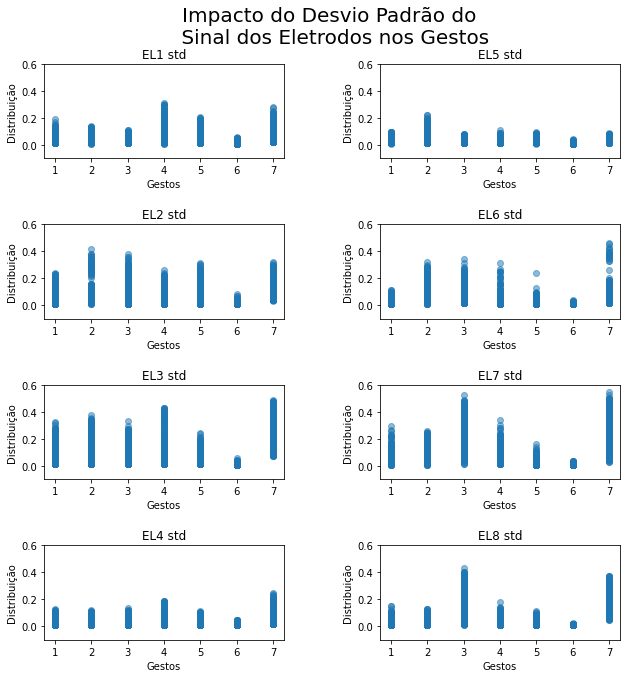

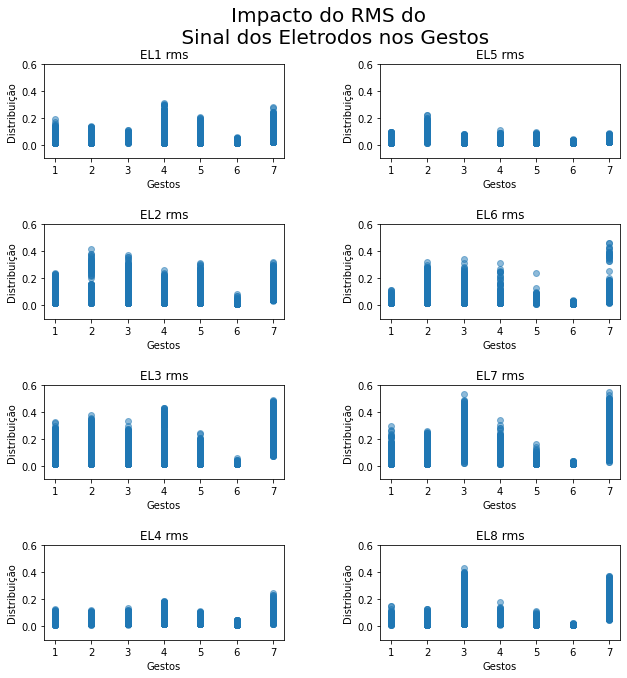

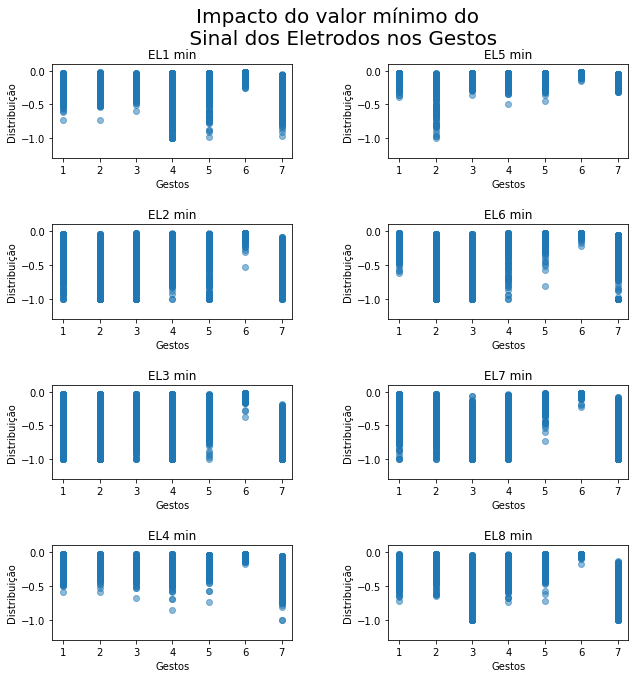

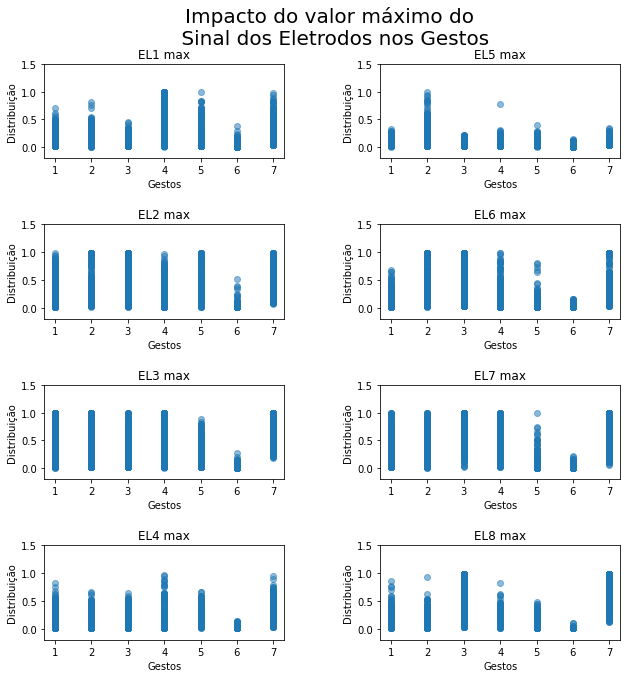

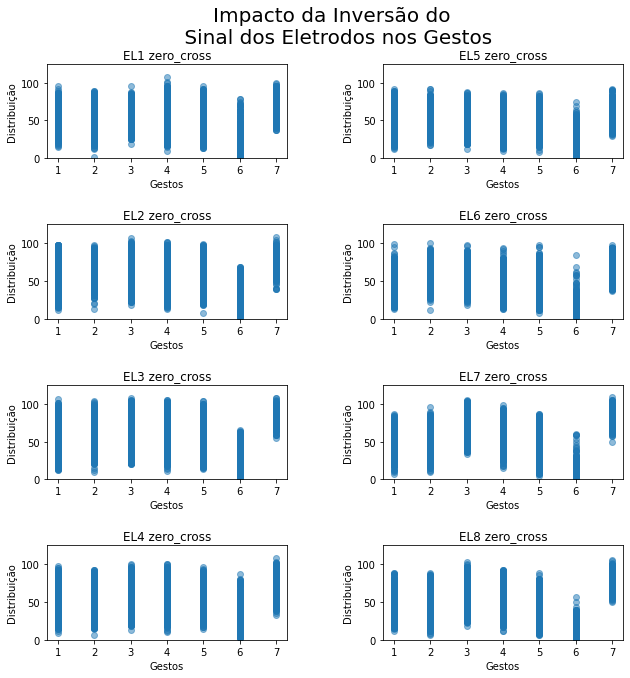

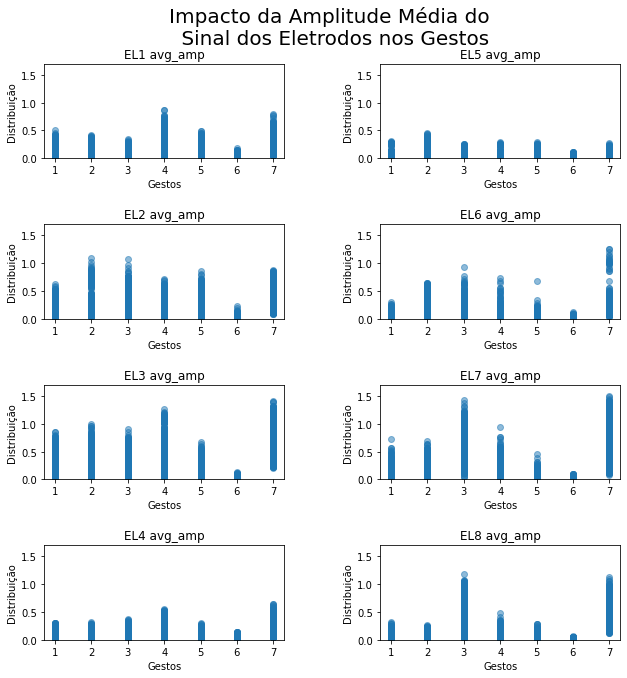

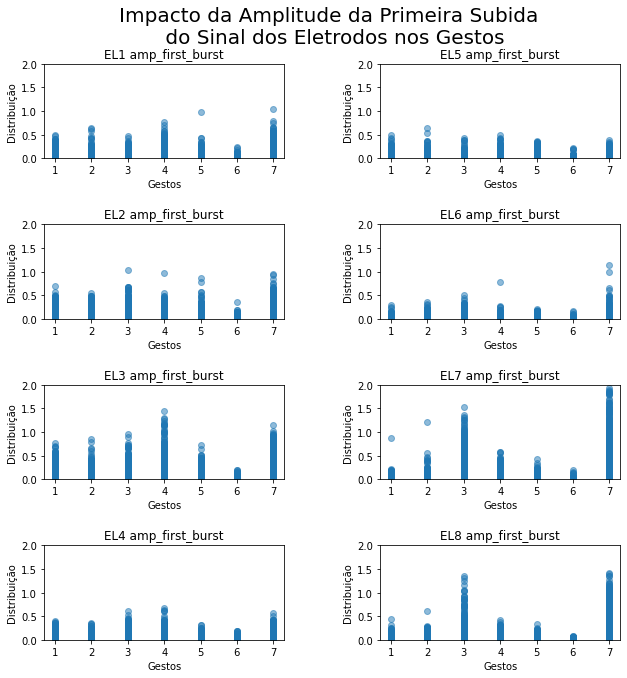

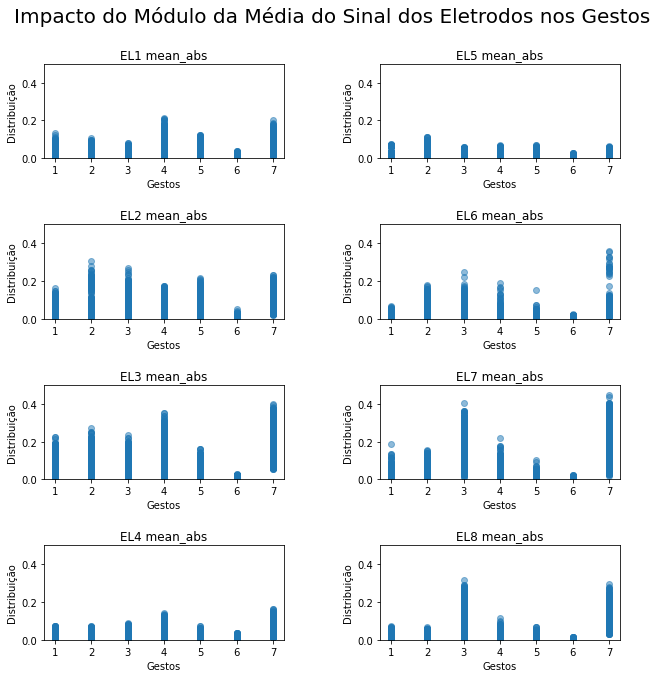

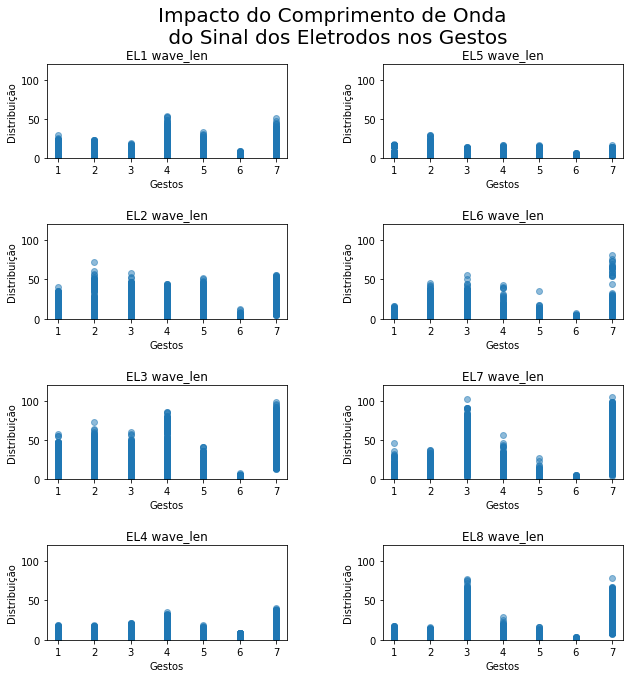

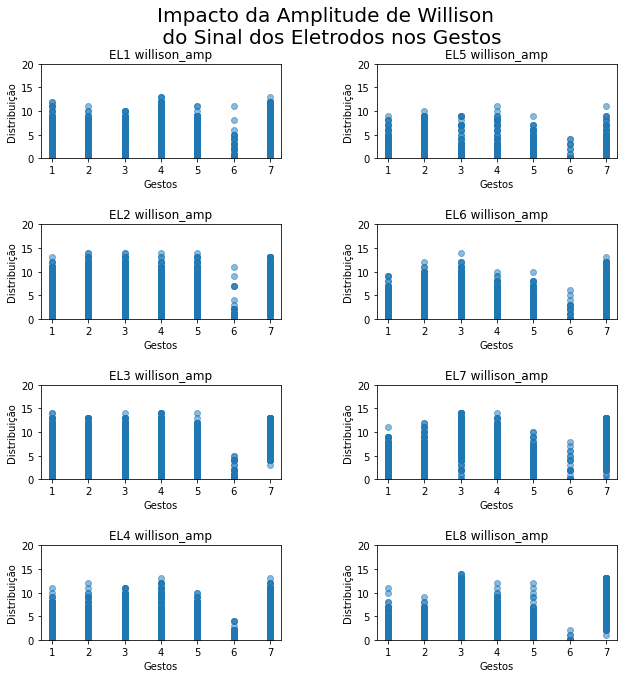

In [ ]:
suptitles = ['Impacto do Desvio Padrão do \n Sinal dos Eletrodos nos Gestos',
             'Impacto do RMS do \n Sinal dos Eletrodos nos Gestos',
             'Impacto do valor mínimo do \n Sinal dos Eletrodos nos Gestos',
             'Impacto do valor máximo do \n Sinal dos Eletrodos nos Gestos',
             'Impacto da Inversão do \n Sinal dos Eletrodos nos Gestos',
             'Impacto da Amplitude Média do \n Sinal dos Eletrodos nos Gestos',
             'Impacto da Amplitude da Primeira Subida \n do Sinal dos Eletrodos nos Gestos',
             'Impacto do Módulo da Média do Sinal dos Eletrodos nos Gestos',
             'Impacto do Comprimento de Onda \n do Sinal dos Eletrodos nos Gestos',
             'Impacto da Amplitude de Willison \n do Sinal dos Eletrodos nos Gestos']

ylims = [[-0.1,0.6],[-0.1,0.6],[-1.3,0.1],[-0.2,1.5],[0,125],[0,1.7],[0,2],
         [0,0.5],[0,120],[0,20]]

for figure in range(0,10):
  fig, axs = plt.subplots(4, 2,figsize=(10,10))
  fig.suptitle(suptitles[figure],
              fontsize=20)
  shift = 8*figure;
  for graph in range(0,8):
    y = df.iloc[:,graph + shift]
    x = df['gesture']
    if graph <= 3:
      axs[graph, 0].scatter(x, y, alpha=0.5)
      axs[graph, 0].set_title(df.columns[graph + shift])
      axs[graph, 0].set_ylabel('Distribuição')
      axs[graph, 0].set_xlabel('Gestos')
      axs[graph, 0].set_ylim(ylims[figure])
    else:
      axs[graph-4, 1].scatter(x, y, alpha=0.5)
      axs[graph-4, 1].set_title(df.columns[graph + shift])
      axs[graph-4, 1].set_ylabel('Distribuição')
      axs[graph-4, 1].set_xlabel('Gestos')
      axs[graph-4, 1].set_ylim(ylims[figure])

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.7)

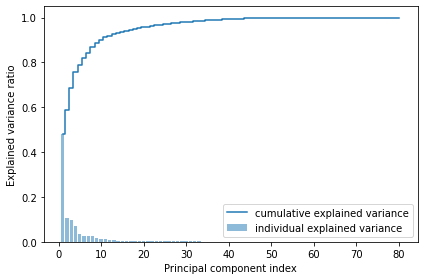

In [ ]:
sc = StandardScaler()
df_sc = sc.fit_transform(df.iloc[:,:80])

cov_mat = np.cov(df_sc.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in eigen_vals]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 81), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 81), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Treino prévio de classificadores**

In [ ]:
X = df.iloc[:, :79].values
y = df.iloc[:, 80].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y)

In [ ]:
svm = SVC(kernel='linear', 
          random_state=1, 
          gamma=0.00001, 
          C=8.0)
svmg = SVC(kernel='rbf', 
           random_state=1, 
           gamma=0.0001, 
           C=80.0)
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=5, 
                              random_state=1)
rfc = RandomForestClassifier(max_depth=5, 
                             random_state=1)
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(penalty='l2', random_state=1)

classifiers = [svm, svmg, tree, rfc, knn, lr]
classifiers_names = ['SVM Linear', 'SVM Gaussian','Decision Tree',
                     'Random Forest', 'k-nearest neighbors',
                     'LogisticRegression']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale th

Text(0.5, 1.0, 'PCA')

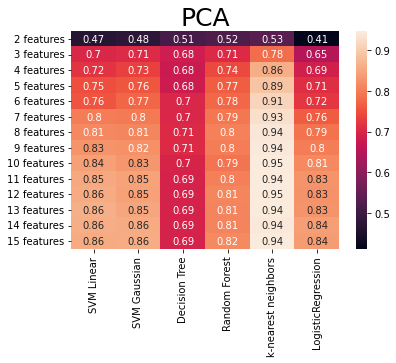

In [ ]:
max_main_features = 15
classifier_num = 6
scores_pca = np.zeros((max_main_features-1,classifier_num))

indexes = pd.Series([])
for features in range(2,max_main_features + 1):
  indexes[features] = str(features) + ' features'

for classifier in range(0, classifier_num):
  for features in range(2, max_main_features + 1):
    pipe_train_pca = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=features)),
                               ("classifier",classifiers[classifier])])
    pipe_test_pca = Pipeline([('scaler', StandardScaler()),
                              ('pca', PCA(n_components=features))])
    pipe_train_pca.fit(X_train, y_train)
    pipe_test_pca.fit(X_test, y_test)
    test_score = pipe_train_pca.score(X_test, y_test)

    scores_pca[features-2][classifier] = test_score

scores_pca_df = pd.DataFrame(scores_pca)
scores_pca_df.columns = classifiers_names
scores_pca_df.index  = indexes
sns.heatmap(scores_pca_df, annot=True).set_title('PCA', 
                                                 fontdict={'fontsize':25})

# **Tuning de hiperparâmetros SVM**

In [ ]:
pipe_svc = Pipeline([('scaler', StandardScaler()),
                               ('svc', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9440926993149305
{'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [ ]:
pipe_svc = Pipeline([('scaler', StandardScaler()),
                               ('svc', SVC(random_state=1))])

param_range_C = [10.0, 12.5, 15.0, 17.5, 20.0]
param_range_g = [0.042,0.043,0.044]

param_grid = {'svc__C': param_range_C, 
               'svc__gamma': param_range_g, 
               'svc__kernel': ['rbf']}

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9549827636114839
{'svc__C': 12.5, 'svc__gamma': 0.043, 'svc__kernel': 'rbf'}


# **Tuning de hiperparâmetros Decision Tree**

In [ ]:
pipe_tree = Pipeline([('scaler', StandardScaler()),
                               ('tree', DecisionTreeClassifier(random_state=1))])

param_grid = {
    'tree__max_depth': [1, 2, 3, 4, 5, 10, 20, 50],
    'tree__min_samples_leaf': [1, 2, 3, 4, 5, 10, 20],
    'tree__criterion': ["gini", "entropy"]
}

gs = GridSearchCV(estimator=pipe_tree, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8582493443155006
{'tree__criterion': 'entropy', 'tree__max_depth': 20, 'tree__min_samples_leaf': 1}


# **Tuning de hiperparâmetros Random Forest**

In [ ]:
pipe_random = Pipeline([('scaler', StandardScaler()),
                               ('random', RandomForestClassifier(random_state=1))])

param_grid = {
    'random__bootstrap': [True],
    'random__max_depth': [30, 40, 50, 60, 70, 80],
    'random__max_features': [3, 4, 5 , 6, 7, 8],
    'random__min_samples_leaf': [1, 2, 3],
    'random__min_samples_split': [4, 5, 6, 7, 8],
    'random__n_estimators': [250, 300, 350]
}

gs = GridSearchCV(estimator=pipe_random, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9405309509398876
{'random__bootstrap': True, 'random__max_depth': 80, 'random__max_features': 3, 'random__min_samples_leaf': 3, 'random__min_samples_split': 8, 'random__n_estimators': 300}


# **Tuning de hiperparâmetros KNN**

In [ ]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                               ('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'knn__weights' : ['uniform','distance'],
    'knn__metric' : ['minkowski','euclidean','manhattan']
}

gs = GridSearchCV(estimator=pipe_knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.964198749155724
{'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


# **Tuning de hiperparâmetros Logistic Regression**

In [ ]:
pipe_lr = Pipeline([('scaler', StandardScaler()),
                               ('lr', LogisticRegression(random_state=1))])

param_grid = {
    'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'lr__penalty' : ['l2'],
    'lr__C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

0.8892327394893117
{'lr__C': 10000.0, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


# **Análise de curva SVM**
> Utilizando hiperparâmetros tunados e PCA para 35 features

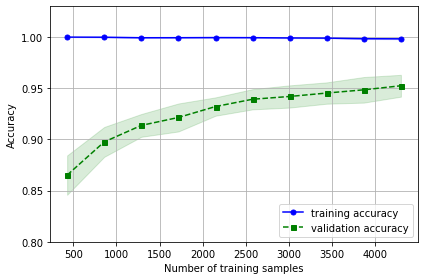

In [ ]:
classifier =  SVC(kernel='rbf',
                  random_state=1,
                  gamma=0.043,
                  C=12.5)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=35)), 
                 ("classifier",classifier)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# **Análise de curva Decision Tree**
> Utilizando hiperparâmetros tunados e PCA para 35 features

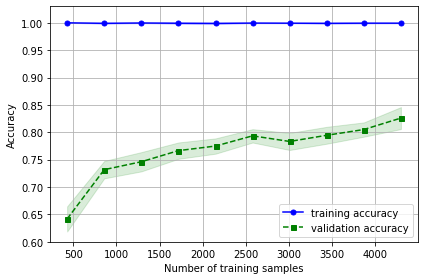

In [ ]:
classifier =  DecisionTreeClassifier(criterion='entropy', 
                              max_depth=20, 
                              min_samples_leaf=1,
                              random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=35)), 
                 ("classifier",classifier)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.03])
plt.tight_layout()
plt.show()

# **Análise de curva Random Forest**
> Utilizando hiperparâmetros tunados e PCA para 35 features



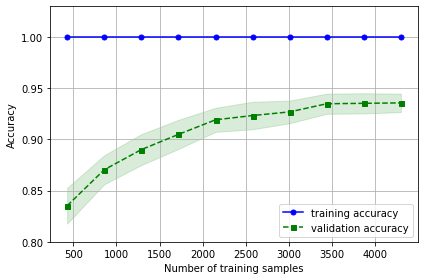

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5, 
                                  weights='distance', 
                                  metric='manhattan')

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=35)), 
                 ("classifier",classifier)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# **Análise de curva KNN**
> Utilizando hiperparâmetros tunados e PCA para 35 features

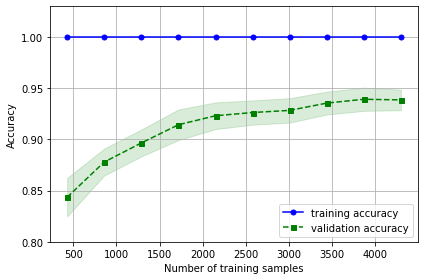

In [ ]:
classifier =  KNeighborsClassifier(metric='manhattan',
                           n_neighbors=4,
                           weights='distance')

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=35)), 
                 ("classifier",classifier)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# **Análise de curva Logistic Regression**
> Utilizando hiperparâmetros tunados e PCA para 35 features

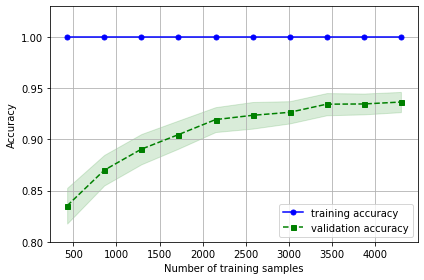

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5, 
                                  weights='distance', 
                                  metric='manhattan')

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=35)), 
                 ("classifier",classifier)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# **Validação Cruzada K-Fold**
> Validação cruzada dos classificadores com hiperparametros tunados



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Text(0.5, 1.0, 'K-FOLD')

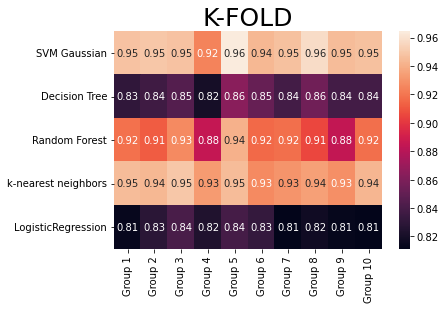

In [ ]:
svmg = SVC(kernel='rbf', 
           random_state=1, 
           gamma=0.043, 
           C=12.5)
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=20, 
                              min_samples_leaf=1,
                              random_state=1)
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=80, 
                             max_features=3,
                             min_samples_leaf=3,
                             min_samples_split=8,
                             n_estimators=300,
                             random_state=1)
knn = KNeighborsClassifier(metric='manhattan',
                           n_neighbors=5,
                           weights='distance')
lr = LogisticRegression(C=10000,
                        penalty='l2',
                        solver='newton-cg', 
                        random_state=1)

classifiers = [svmg, tree, rfc, knn, lr]
classifiers_names = ['SVM Gaussian','Decision Tree',
                     'Random Forest', 'k-nearest neighbors',
                     'LogisticRegression']

indexes = pd.Series([])
for features in range(1,11):
  indexes[features] = 'Group ' + str(features)

scores = np.zeros((5,10))
for classifier in range(len(classifiers)):
  pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifiers[classifier])])
  pipe_train.fit(X_train, y_train)

  kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
  for k, (train, test) in enumerate(kfold):
      pipe_train.fit(X_train[train], y_train[train])
      score = pipe_train.score(X_train[test], y_train[test])
      scores[classifier][k] = score

scores = pd.DataFrame(scores)
scores.columns = indexes
scores.index  = classifiers_names
sns.heatmap(scores, annot=True).set_title('K-FOLD', fontdict={'fontsize':25})

# **Análise de erro SVM - Confusion Matrix**

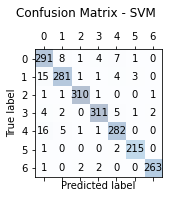

Acerto para dedo indicador: 0.9079563182527302
Acerto para dedo médio: 0.9335548172757475
Acerto para dedo anelar: 0.9856915739268679
Acerto para dedo mínimo: 0.9643410852713179
Acerto para dedo polegar: 0.9322314049586777
Acerto para repouso: 0.9817351598173516
Acerto para gesto vitória: 0.9850187265917604


In [ ]:
classifier = SVC(kernel='rbf', 
                 random_state=1, 
                 gamma=0.043, 
                 C=12.5)
pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifier)])
pipe_train.fit(X_train, y_train)
y_pred = pipe_train.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.suptitle('Confusion Matrix - SVM', y=1.08)
plt.tight_layout()
plt.show()

y_true = y_test
ac = f1_score(y_true, y_pred, average=None)
print('Acerto para dedo indicador: '+str(ac[0]))
print('Acerto para dedo médio: '+str(ac[1]))
print('Acerto para dedo anelar: '+str(ac[2]))
print('Acerto para dedo mínimo: '+str(ac[3]))
print('Acerto para dedo polegar: '+str(ac[4]))
print('Acerto para repouso: '+str(ac[5]))
print('Acerto para gesto vitória: '+str(ac[6]))

# **Análise de erro Decision Tree - Confusion Matrix**

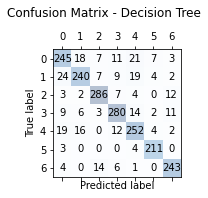

Acerto para dedo indicador: 0.7915993537964459
Acerto para dedo médio: 0.8177172061328791
Acerto para dedo anelar: 0.9064976228209192
Acerto para dedo mínimo: 0.8615384615384615
Acerto para dedo polegar: 0.8129032258064516
Acerto para repouso: 0.9461883408071748
Acerto para gesto vitória: 0.8983364140480591


In [ ]:
classifier = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=20, 
                              min_samples_leaf=1,
                              random_state=1)
pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifier)])
pipe_train.fit(X_train, y_train)
y_pred = pipe_train.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.suptitle('Confusion Matrix - Decision Tree', y=1.08)
plt.tight_layout()
plt.show()

y_true = y_test
ac = f1_score(y_true, y_pred, average=None)
print('Acerto para dedo indicador: '+str(ac[0]))
print('Acerto para dedo médio: '+str(ac[1]))
print('Acerto para dedo anelar: '+str(ac[2]))
print('Acerto para dedo mínimo: '+str(ac[3]))
print('Acerto para dedo polegar: '+str(ac[4]))
print('Acerto para repouso: '+str(ac[5]))
print('Acerto para gesto vitória: '+str(ac[6]))

# **Análise de erro Random Forest - Confusion Matrix**

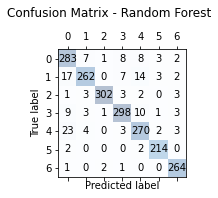

Acerto para dedo indicador: 0.8734567901234568
Acerto para dedo médio: 0.8972602739726027
Acerto para dedo anelar: 0.9741935483870968
Acerto para dedo mínimo: 0.9240310077519381
Acerto para dedo polegar: 0.8837970540098199
Acerto para repouso: 0.9705215419501134
Acerto para gesto vitória: 0.9688073394495413


In [ ]:
classifier = RandomForestClassifier(bootstrap=True,
                             max_depth=80, 
                             max_features=3,
                             min_samples_leaf=3,
                             min_samples_split=8,
                             n_estimators=300,
                             random_state=1)
pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifier)])
pipe_train.fit(X_train, y_train)
y_pred = pipe_train.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.suptitle('Confusion Matrix - Random Forest', y=1.08)
plt.tight_layout()
plt.show()

y_true = y_test
ac = f1_score(y_true, y_pred, average=None)
print('Acerto para dedo indicador: '+str(ac[0]))
print('Acerto para dedo médio: '+str(ac[1]))
print('Acerto para dedo anelar: '+str(ac[2]))
print('Acerto para dedo mínimo: '+str(ac[3]))
print('Acerto para dedo polegar: '+str(ac[4]))
print('Acerto para repouso: '+str(ac[5]))
print('Acerto para gesto vitória: '+str(ac[6]))

# **Análise de erro KNN - Confusion Matrix**

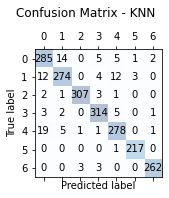

Acerto para dedo indicador: 0.9004739336492891
Acerto para dedo médio: 0.9118136439267887
Acerto para dedo anelar: 0.9824
Acerto para dedo mínimo: 0.9587786259541985
Acerto para dedo polegar: 0.9159802306425041
Acerto para repouso: 0.9886104783599088
Acerto para gesto vitória: 0.9812734082397004


In [ ]:
classifier = KNeighborsClassifier(metric='manhattan',
                           n_neighbors=5,
                           weights='distance')
pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifier)])
pipe_train.fit(X_train, y_train)
y_pred = pipe_train.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.suptitle('Confusion Matrix - KNN', y=1.08)
plt.tight_layout()
plt.show()

y_true = y_test
ac = f1_score(y_true, y_pred, average=None)
print('Acerto para dedo indicador: '+str(ac[0]))
print('Acerto para dedo médio: '+str(ac[1]))
print('Acerto para dedo anelar: '+str(ac[2]))
print('Acerto para dedo mínimo: '+str(ac[3]))
print('Acerto para dedo polegar: '+str(ac[4]))
print('Acerto para repouso: '+str(ac[5]))
print('Acerto para gesto vitória: '+str(ac[6]))

# **Análise de erro Logistic Regression - Confusion Matrix**

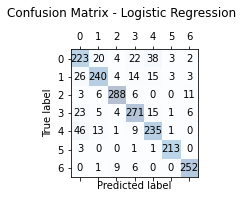

Acerto para dedo indicador: 0.7012578616352202
Acerto para dedo médio: 0.8135593220338982
Acerto para dedo anelar: 0.9230769230769231
Acerto para dedo mínimo: 0.8287461773700305
Acerto para dedo polegar: 0.7717569786535303
Acerto para repouso: 0.9703872437357632
Acerto para gesto vitória: 0.929889298892989


In [ ]:
classifier = LogisticRegression(C=10000,
                        penalty='l2',
                        solver='newton-cg', 
                        random_state=1)
pipe_train = Pipeline([('scaler', StandardScaler()),
                               ('pca', PCA(n_components=15)),
                               ("classifier",classifier)])
pipe_train.fit(X_train, y_train)
y_pred = pipe_train.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.suptitle('Confusion Matrix - Logistic Regression', y=1.08)
plt.tight_layout()
plt.show()

y_true = y_test
ac = f1_score(y_true, y_pred, average=None)
print('Acerto para dedo indicador: '+str(ac[0]))
print('Acerto para dedo médio: '+str(ac[1]))
print('Acerto para dedo anelar: '+str(ac[2]))
print('Acerto para dedo mínimo: '+str(ac[3]))
print('Acerto para dedo polegar: '+str(ac[4]))
print('Acerto para repouso: '+str(ac[5]))
print('Acerto para gesto vitória: '+str(ac[6]))